# Graph-to-Combinatorial GraphCurve Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

/Users/gescalona/miniforge3/envs/topox/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# Matroids
Matroids $\mathcal{M} = (S, \mathcal{I})$ defined on a ground set $S$ are simplicial complexes with a special exchange/augmenting property, that is:
$$
\forall X, Y \in \mathcal{I}, |X| < |Y| \rightarrow \exists z \in Y - X, X + z \in \mathcal{I} 
$$
In particular, we say that $X$ is **independent** for $X \in \mathcal{I}$. The property suggests that there are maximal such sets $B$. We say that $B$ is **base** for $\mathcal{M}$. We can construct all independent sets from $\mathcal{B} = \{B : B \text{ is a base of } \mathcal{M}\}$.

Tied to any matroid is a *submodular* $\mathit{rank}_\mathcal{M}$ function, where if $X \in \mathcal{I}$, $\mathit{rank}(X) = |X|$. The fact that it is submodular is very important, but we leave this distrinction to another setting.

In order to modify matroids to be a combinatorial complex, it is enough to:
- Remove $\emptyset$ from $\mathit{I}$
- Set $\mathcal{rnk}(X) = \mathcal{rank}_M(X) - 1$

If $X \not\in \mathcal{I}$, then $X$ is considered dependent. Similar to bases, dependent-wise minimal sets are called **circuits**. These are also another characterizations of matroids, where any proper subset of circuits are independent in $\mathcal{M}$.

These four equivalent characterizations of matroids: *independent* sets, bases, circuits, and rank function as well as a ground set $S$ are used to construct matroids throughout the codebase.

For further discussion on the topic, Oxley's book is widely recommended.

## Graphic Curve Lifting Explanation

In order to make a Graph Curve Matroid, we need the following (from some graph $G = (V, E)$):
- The graphic matroid of the graph $G$: $M(G) = (E, \mathcal{I})$
- Its dual $M^* = M^*(G) = (E, \mathcal{I}^*)$, the bond matroid, and its rank function: $\mathit{rank}^*: 2^E \to \mathbb{Z}_+$.


## Dual Matroid
A dual matroid of another matroid is where the bases of the dual matroid are the complements of the original matroid's bases. Formally, if $\mathcal{M} = (S, \mathcal{B})$, then let $\mathcal{B}^* = \{S - B : \forall B \in \mathcal{B}\}$, so that the dual of the matroid $\mathcal{M}$ is defined as $\mathcal{M}^* = (S, \mathcal{B}^*)$

## Graphic Matroid
A graphic matroid is a matroid where its bases are the edges that make the maximum spanning trees of the graph $G$. We denote $M(G) = (E, \mathit{I})$, where $G = (V, E)$ and $I \in \mathcal{I}$ if $I$ is a forest/spanning tree of $G$.

## Bond Matroid
A bond matroid is a matroid where its independent sets are the edges that when removed, retain the number of connected components of the graph. Formally, if $G = (V, E)$, then let $\mathcal{M}^*(G) = (E, \mathcal{I}^*)$. For $X \subseteq E$, if $X \in \mathcal{I}^*$, then the graph induced by removing $X$ from $E$ of $G$ had no more or less connected components. The bases of $\mathcal{M}^*(G)$ are maximal such sets, its circuits are the minimal sets that do increase the number of connected components. For $X \subseteq E$, $\mathit{rank}_{\mathcal{M}^*(G)}(X)$ is the maximal number of edge deletions from $X$ that do not increase the number as well.

One thing is important to note about this matroid: from graph theory, we know that unique duals of nonplanar graphs do not exist, meaning it is harder to analyze the graphs by their (nonunique) duals. However, for a graphic matroid, a unique dual **always** exists, which is a nice property. 

## Graphic Curve Matroid
The idea now is to use the bond matroids, but there is one problem: the ground set is based on edges, instead of vertices. We can always make a trivial reduction from edges to vertices by means of incidence, however, some natural reductions exist. One of these is called the **Graph Curve Matroids**, introduced recently by Alheydis Geiger, Kevin Kühn, and Raluca Vlad. These matroids are directly related to hyperplanes of graph curves, hence the name.

(Proposition 2.3): Given $G = (V, E)$, and $M(G)$, its graphic matroid, we can construct the Graph Curve Matroid $M_g = (V, \mathcal{I})$, where $A \subseteq V$:
- is dependent in $M_g$ iff $\exists$ nonempty $A' \subseteq A, \mathit{rank}_{\mathcal{M}^*(G)}(A') \leq |A'|$
- is independent in $M_g$ iff $\forall$ nonempty $A' \subseteq A, \mathit{rank}_{\mathcal{M}^*(G)}(A') > |A'|$

where $\delta(A)$ refers to the edges incident to the vertices in $A$. The above was shown in [1]. Admittedly, while well-defined, these definitions are not intuitve. We go into more detail for a double house graph that I added that is used in the paper as a prominent example.


[1] Geiger, Alheydis, Kevin Kuehn, and Raluca Vlad. "Graph Curve Matroids." arXiv preprint arXiv:2311.08332 (2023). https://arxiv.org/abs/2311.08332.

[2] H. Whitney, On the abstract properties of linear dependence, Amer. J. Math. 57(3) (1935) 509–533.

In [2]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2combinatorial/curve_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2combinatorial/curve_lifting:

{'transform_type': 'lifting',
 'transform_name': 'CurveLifting',
 'feature_lifting': 'ProjectionSum',
 'max_rank': 2}


## Loading the Dataset: Manual

In [3]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}



Dataset contains 2 samples.

Providing more details about sample 0/2:


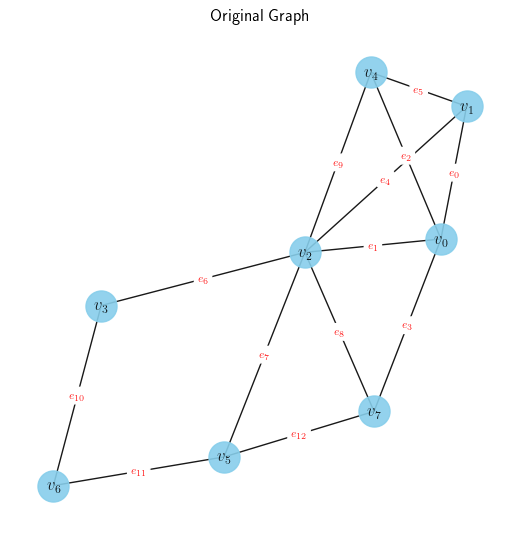

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [4]:
dataset = loader.load()
describe_data(dataset, 0)


Dataset contains 2 samples.

Providing more details about sample 1/2:


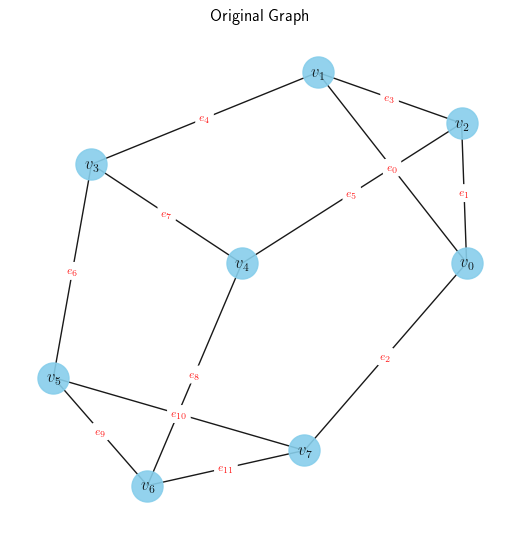

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [5]:
describe_data(dataset, 1)  # this is the double house graph

We than apply the transform via our `PreProcesor`:

Transform parameters are the same, using existing data_dir: /Users/gescalona/Desktop/challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/4211167841

Dataset contains 2 samples.

Providing more details about sample 0/2:


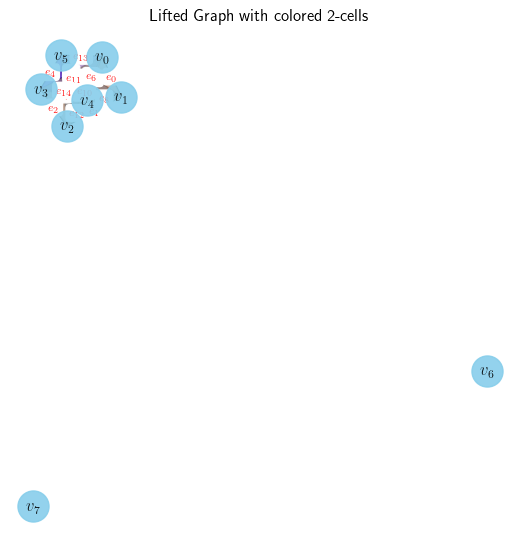

 - The complex has 6 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 15 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 20 2-cells.
 - The 2-cells have features dimension 1



In [6]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset, 0)


Dataset contains 2 samples.

Providing more details about sample 1/2:


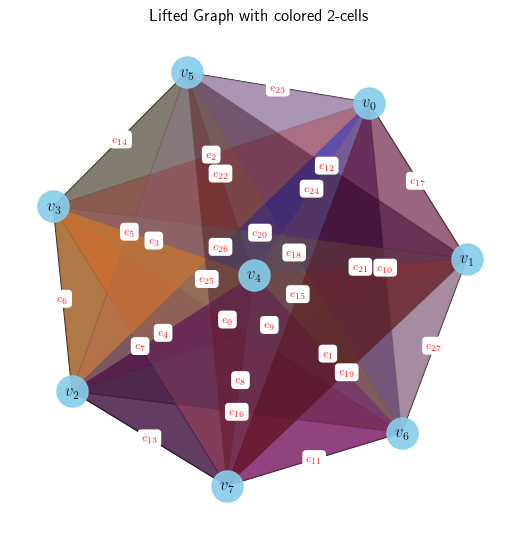

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 54 2-cells.
 - The 2-cells have features dimension 1



In [7]:
describe_data(lifted_dataset, 1)

First, I would like to note that the `describe_data` method may have weird visualization issues. It may be better to view the actual bases/circuits on their own (scroll all the way at bottom).

Graphs that are not trivalent ($\forall v \in V, \mathit{deg}(v) >= 3$) are not that interesting, and the [1] focuses on these types of graphs. In fact, with that assumption, we can revise proposition 2.3 with the following:
Let $G = (V, E)$. First, let $\omega(A) = $ the number of connected components of the subgraph induced by $G$ on $A$, where $A$ is a vertex-set.

(Proposition 3.1): Let $A \subseteq V$. $A$ is a circuit of $M_g$ iff:
- $A$ is a cycle.
- $A$ is acyclic and $\omega(V - A) = \omega(A) + 1$.

(Proposition 3.3): If $A$ is acyclic, then $A$:
- is dependent in $M_g$ iff $\exists$ nonempty $A' \subseteq A$, $\omega(A') < \omega(V - A')$
- is independent in $M_g$ iff $\forall$ nonempty $A' \subseteq A$, $\omega(A') \geq \omega(V - A')$

The above propositions are a lot more descriptive vs proposition 2.3.

Example 2.4: $A = \{0,1,2 \}$ is a dependent set/circuit because it is a cycle in $G$. 

Example 3.4: Let $A = \{1, 2, 4, 5, 6\}$. $A$ is a circuit because $\omega(V - A) = \omega(A) + 1$

Example A: Let $A = \{0, 1, 7\}$. $A$ is a 2-cell (matroid rank 3), and it is independent. Try removing any of its subsets and see if the resulting graph is disconnected. We can also see that it's an acycle. This corresponds to a hyperedge on the combinatorial complex.

(Lemma 4.4): If $B \in \mathcal{B}_{\mathcal{M}_g}$, then equality of propsition 3.3 is achieved, ie $\omega(B) = \omega(V - B)$

Example B: Let $A = \{1, 2, 6, 7\}$. By computation, this is a basis (see below). $A$ is a basis because we can separate the graphs to 2 connected components, where $A$ is one and $V - A$ is another.

I will say this again, but since the `max_rank` is set to $2$ in order to be compliant with the HMC model, higher order information does not exist, such as esp Example 3.4 and Example B. See the Extra section where I lift this restriction

One limitation is that the graphic curve matroid is hard to compute, it requires checking every subset of a possible candidate set to make the graphic curve matroid. Not to mention that creating the graphic and cographic matroids are also expensive as well. At the moment, this is a *deterministic* lifting that calculates every spanning tree, however, an *indeterministic* lifting exists by sampling bases of a matroid.

## Create and Run a Combinatorial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `adjacency_0`, `adjacency_1`, `adjacency_2`, `incidence_1`, `incidence_2` so the lifting should make sure to add them to the data.

At the moment, the `max_rank` config option shrinks any matroid down to a basis of 3 elements in order to ensure that the Preprocessor runs correctly, but this actually a genuine limitation, since the full basis of a matroid describes a lot of information.

In [8]:
from modules.models.combinatorial.hmc import HMCModel

model_type = "combinatorial"
model_id = "hmc"
model_config = load_model_config(model_type, model_id)

model = HMCModel(model_config, dataset_config)


Model configuration for combinatorial HMC:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'negative_slope': 0.2}


In [9]:
y_hat = model(lifted_dataset.get(0))
y_hat = model(lifted_dataset.get(1))

/Users/gescalona/miniforge3/envs/topox/lib/python3.11/site-packages/topomodelx/nn/combinatorial/hmc_layer.py:680: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  A_p = torch.sparse.mm(A_p, neighborhood)


If everything is correct the cell above should execute without errors. 

I think one thing to point out is that the incidence matrix can better be defined with using the exchange/augmentation property. This means that we can have more descriptive incidence matrices.

If $X, Y \in \mathcal{I}, |X| + 1 = |Y|$, let $Z_{X, Y} = \{z : \forall z \in Y - X, X + z \in \mathcal{I}\}$. The incidence matrix would normally be defined as a,  $f(X, Y) = \delta(X, Y)$, but consider instead $f(X, Y) = g(Z_{X, Y})$, for some $g: Z_{X, Y} \to \mathbb{R}$?

# Extra

In [10]:
from modules.data.utils.utils import load_double_house_graph, load_manual_graph
from modules.transforms.liftings.graph2combinatorial.curve_lifting import (
    GraphCurveMatroidLifting,
)

In [11]:
y = GraphCurveMatroidLifting()

In [12]:
G = load_manual_graph()

In [13]:
manual_curve_matroid = y._graph_curve_matroid(G)

In [14]:
# these are the 3-basis of the graph curve matroid on the manual graph
manual_curve_matroid.skeleton(2)

[frozenset({0, 1, 7}),
 frozenset({0, 2, 5}),
 frozenset({0, 2, 4}),
 frozenset({0, 5, 7}),
 frozenset({1, 5, 7}),
 frozenset({0, 4, 7}),
 frozenset({1, 4, 7}),
 frozenset({1, 2, 7}),
 frozenset({0, 4, 5}),
 frozenset({0, 2, 7}),
 frozenset({0, 1, 2}),
 frozenset({1, 2, 5}),
 frozenset({1, 4, 5}),
 frozenset({2, 4, 7}),
 frozenset({4, 5, 7}),
 frozenset({0, 1, 4}),
 frozenset({2, 5, 7}),
 frozenset({1, 2, 4}),
 frozenset({2, 4, 5}),
 frozenset({0, 1, 5})]

In [15]:
# these are the basis of the graph curve matroid on the manual graph
manual_curve_matroid.skeleton(4)

[frozenset({1, 2, 4, 5, 7}),
 frozenset({0, 2, 4, 5, 7}),
 frozenset({0, 1, 2, 4, 5}),
 frozenset({0, 1, 4, 5, 7}),
 frozenset({0, 1, 2, 5, 7}),
 frozenset({0, 1, 2, 4, 7})]

In [16]:
house_curve_matroid = y._graph_curve_matroid(load_double_house_graph())

In [17]:
# these are the 3-basis of the graph curve matroid on the double house graph
house_curve_matroid.skeleton(2)

[frozenset({0, 1, 7}),
 frozenset({0, 2, 4}),
 frozenset({0, 4, 6}),
 frozenset({1, 3, 7}),
 frozenset({3, 4, 5}),
 frozenset({2, 6, 7}),
 frozenset({0, 1, 3}),
 frozenset({4, 6, 7}),
 frozenset({1, 3, 6}),
 frozenset({0, 6, 7}),
 frozenset({2, 3, 4}),
 frozenset({1, 5, 7}),
 frozenset({0, 3, 5}),
 frozenset({1, 4, 6}),
 frozenset({0, 2, 3}),
 frozenset({1, 2, 7}),
 frozenset({2, 3, 5}),
 frozenset({1, 2, 6}),
 frozenset({0, 3, 4}),
 frozenset({1, 4, 5}),
 frozenset({2, 5, 7}),
 frozenset({2, 4, 5}),
 frozenset({0, 5, 7}),
 frozenset({1, 3, 5}),
 frozenset({0, 2, 5}),
 frozenset({2, 4, 6}),
 frozenset({1, 4, 7}),
 frozenset({0, 4, 5}),
 frozenset({0, 3, 6}),
 frozenset({1, 6, 7}),
 frozenset({3, 4, 6}),
 frozenset({1, 3, 4}),
 frozenset({2, 3, 7}),
 frozenset({2, 3, 6}),
 frozenset({1, 2, 5}),
 frozenset({0, 1, 6}),
 frozenset({3, 6, 7}),
 frozenset({4, 5, 7}),
 frozenset({0, 1, 4}),
 frozenset({0, 3, 7}),
 frozenset({3, 5, 6}),
 frozenset({0, 5, 6}),
 frozenset({4, 5, 6}),
 frozenset(

In [18]:
# these are the basis of the graph curve matroid on the double house graph
house_curve_matroid.skeleton(3)

[frozenset({2, 3, 5, 6}),
 frozenset({0, 3, 4, 6}),
 frozenset({0, 3, 4, 7}),
 frozenset({0, 2, 5, 6}),
 frozenset({2, 4, 5, 6}),
 frozenset({0, 2, 4, 7}),
 frozenset({1, 2, 4, 5}),
 frozenset({0, 1, 3, 5}),
 frozenset({2, 3, 4, 7}),
 frozenset({0, 2, 5, 7}),
 frozenset({1, 2, 3, 5}),
 frozenset({1, 4, 6, 7}),
 frozenset({0, 4, 5, 7}),
 frozenset({1, 2, 4, 7}),
 frozenset({0, 2, 3, 6}),
 frozenset({1, 2, 6, 7}),
 frozenset({2, 3, 4, 6}),
 frozenset({0, 3, 5, 6}),
 frozenset({1, 4, 5, 7}),
 frozenset({0, 1, 6, 7}),
 frozenset({0, 3, 5, 7}),
 frozenset({2, 4, 5, 7}),
 frozenset({2, 3, 4, 5}),
 frozenset({0, 1, 3, 6}),
 frozenset({1, 3, 4, 5}),
 frozenset({2, 4, 6, 7}),
 frozenset({1, 2, 3, 6}),
 frozenset({0, 2, 6, 7}),
 frozenset({1, 3, 6, 7}),
 frozenset({0, 3, 4, 5}),
 frozenset({1, 3, 4, 7}),
 frozenset({1, 3, 4, 6}),
 frozenset({1, 2, 5, 7}),
 frozenset({0, 2, 3, 5}),
 frozenset({1, 2, 4, 6}),
 frozenset({0, 1, 4, 5}),
 frozenset({0, 1, 5, 6}),
 frozenset({0, 1, 5, 7}),
 frozenset({

This is where we explore part of a dataset that [1] references.

The first 5 graphs are trivalent graphs with 8 vertices, and the other 5 are trivalent graphs with 10 vertices

In [19]:
dataset_name = "graph_8"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)
dataset = loader.load()


Dataset configuration for graph_8:

{'data_domain': 'graph',
 'data_type': 'trivalent',
 'data_name': 'graphs_8vertices',
 'data_dir': 'datasets/graph/trivalent',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


In [20]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)

Transform parameters are the same, using existing data_dir: /Users/gescalona/Desktop/challenge-icml-2024/datasets/graph/trivalent/graphs_8vertices/lifting/4211167841


These are the 8-vertex Graphs.


Dataset contains 5 samples.

Providing more details about sample 0/5:


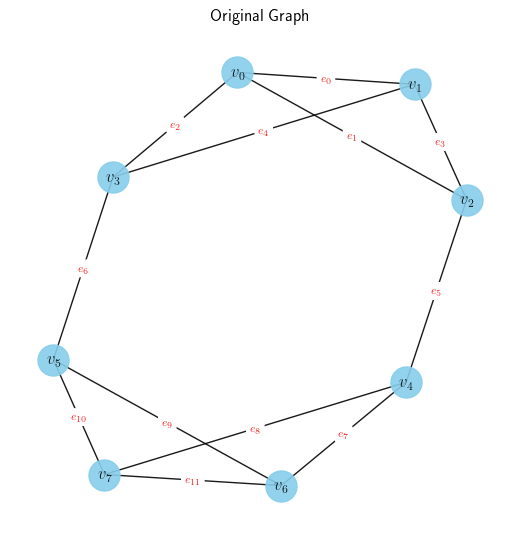

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.


Dataset contains 5 samples.

Providing more details about sample 0/5:


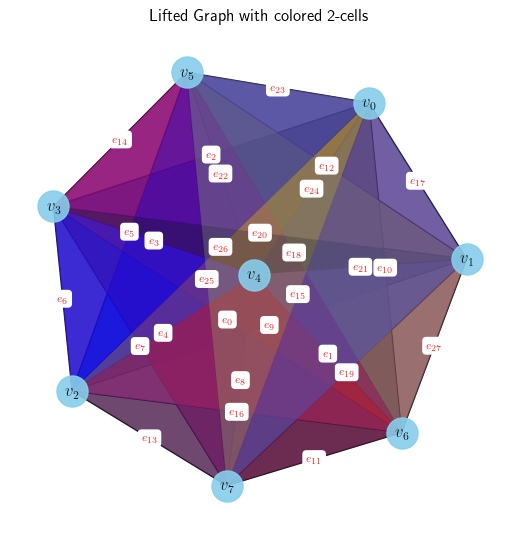

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 48 2-cells.
 - The 2-cells have features dimension 1


Dataset contains 5 samples.

Providing more details about sample 1/5:


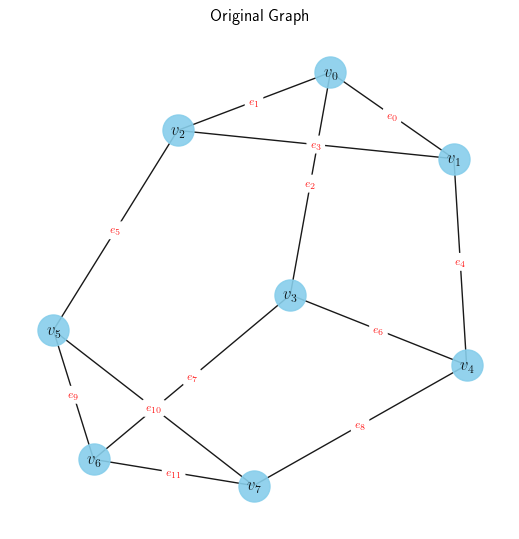

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.


Dataset contains 5 samples.

Providing more details about sample 1/5:


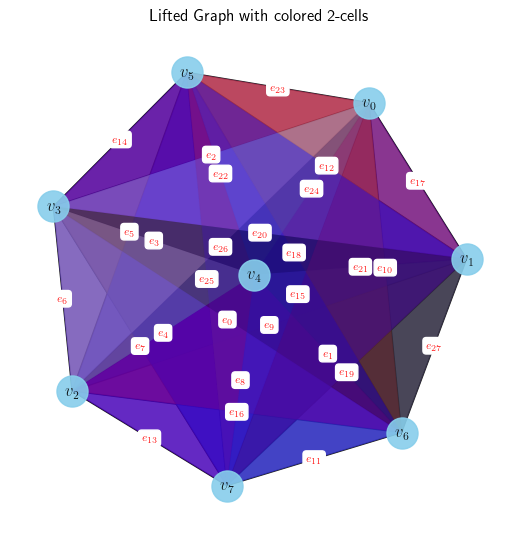

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 54 2-cells.
 - The 2-cells have features dimension 1


Dataset contains 5 samples.

Providing more details about sample 2/5:


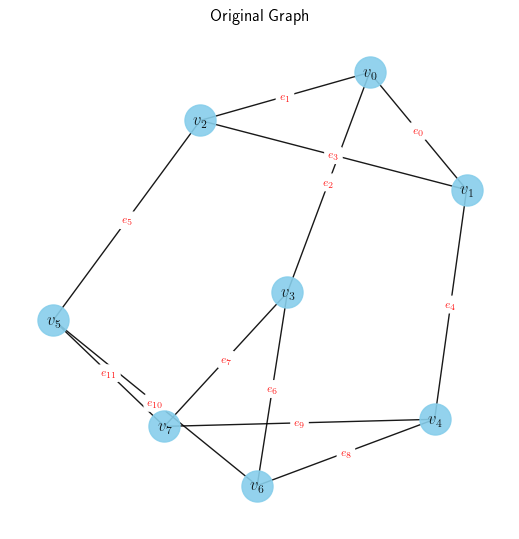

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.


Dataset contains 5 samples.

Providing more details about sample 2/5:


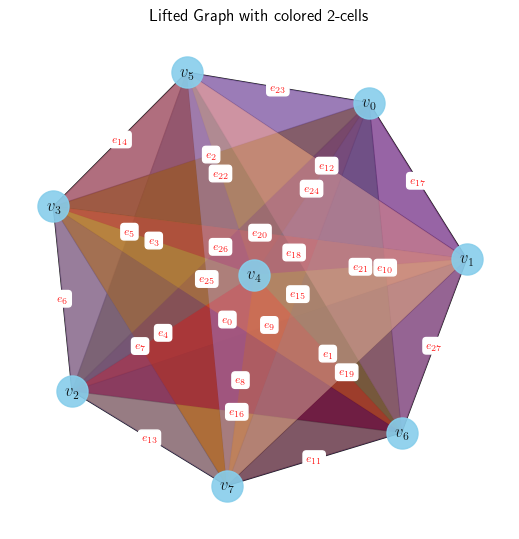

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 55 2-cells.
 - The 2-cells have features dimension 1


Dataset contains 5 samples.

Providing more details about sample 3/5:


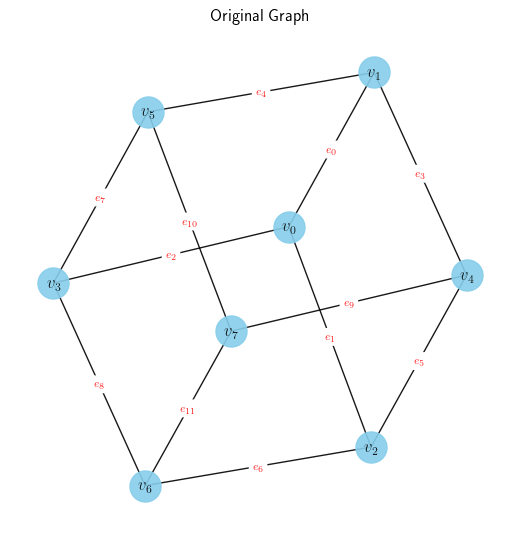

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.


Dataset contains 5 samples.

Providing more details about sample 3/5:


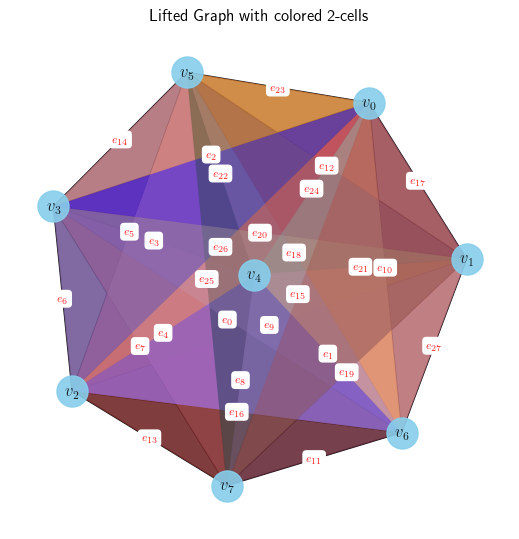

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 56 2-cells.
 - The 2-cells have features dimension 1


Dataset contains 5 samples.

Providing more details about sample 4/5:


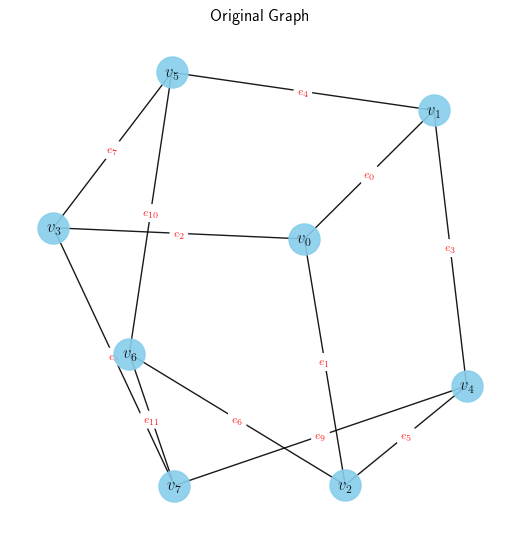

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.


Dataset contains 5 samples.

Providing more details about sample 4/5:


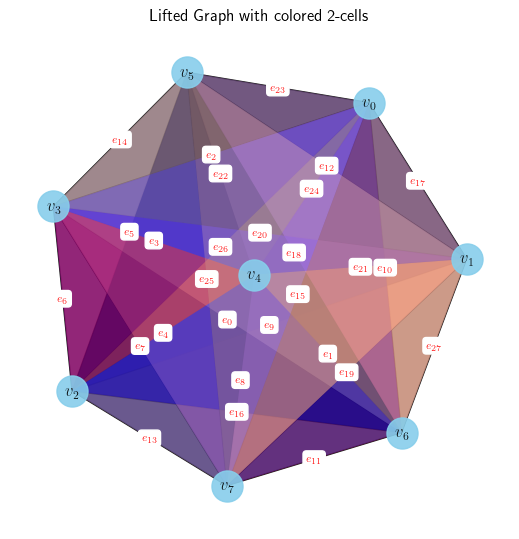

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 56 2-cells.
 - The 2-cells have features dimension 1



In [21]:
for i in range(0, 5):
    describe_data(dataset, i)
    describe_data(lifted_dataset, i)

In [22]:
# disable max_rank, meaning we are not limited to 2-cells.
transform_config["lifting"]["max_rank"] = None

In [23]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)

Transform parameters are the same, using existing data_dir: /Users/gescalona/Desktop/challenge-icml-2024/datasets/graph/trivalent/graphs_8vertices/lifting/1488677257



Dataset contains 5 samples.

Providing more details about sample 0/5:


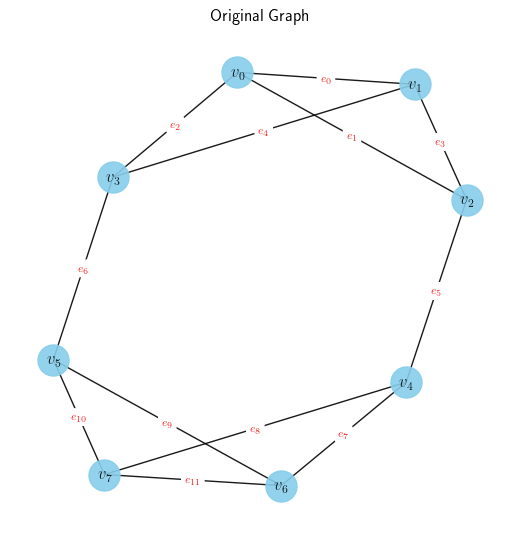

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.


Dataset contains 5 samples.

Providing more details about sample 0/5:


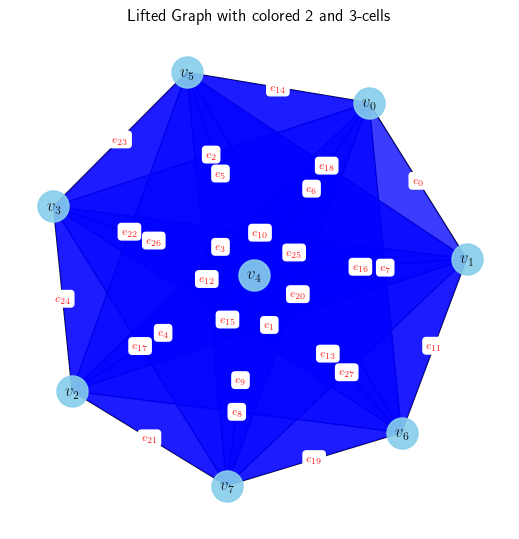

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 48 2-cells.
 - The 2-cells have features dimension 1
 - The complex has 36 3-cells.
 - The 3-cells have features dimension 1


Dataset contains 5 samples.

Providing more details about sample 1/5:


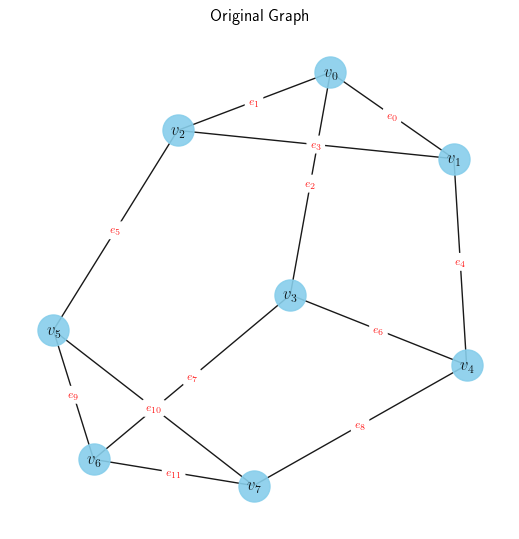

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.


Dataset contains 5 samples.

Providing more details about sample 1/5:


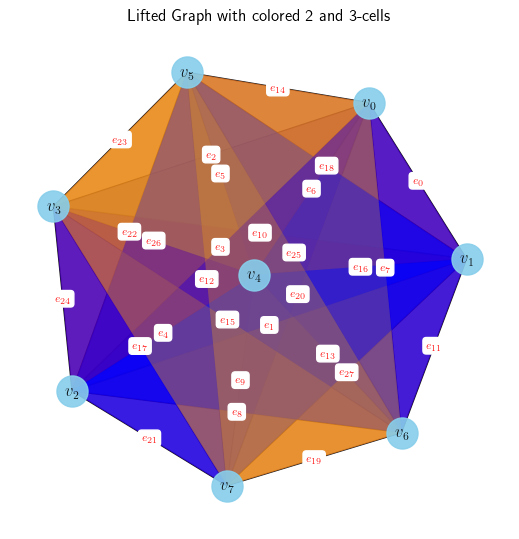

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 54 2-cells.
 - The 2-cells have features dimension 1
 - The complex has 54 3-cells.
 - The 3-cells have features dimension 1


Dataset contains 5 samples.

Providing more details about sample 2/5:


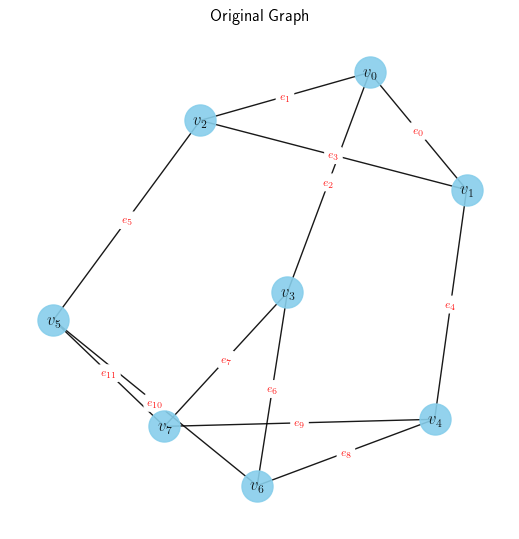

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.


Dataset contains 5 samples.

Providing more details about sample 2/5:


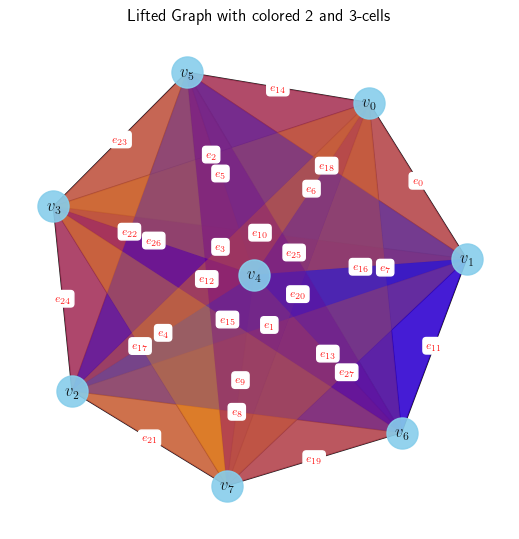

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 55 2-cells.
 - The 2-cells have features dimension 1
 - The complex has 60 3-cells.
 - The 3-cells have features dimension 1


Dataset contains 5 samples.

Providing more details about sample 3/5:


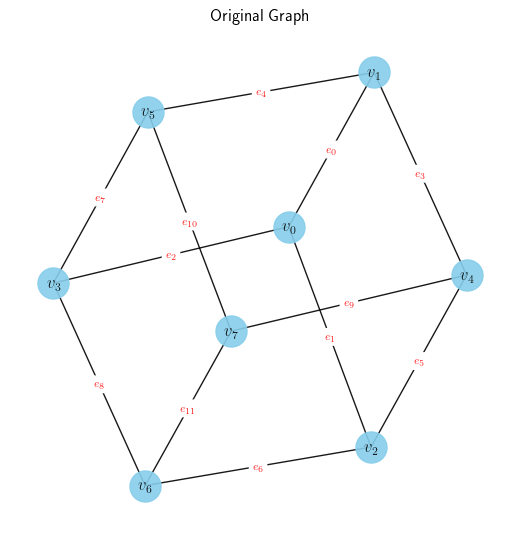

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.


Dataset contains 5 samples.

Providing more details about sample 3/5:


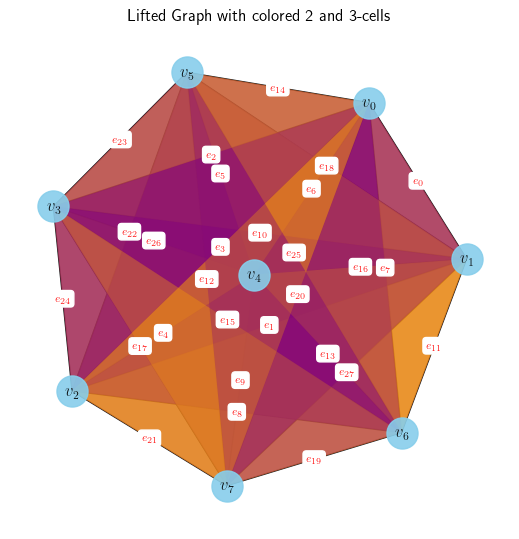

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 56 2-cells.
 - The 2-cells have features dimension 1
 - The complex has 64 3-cells.
 - The 3-cells have features dimension 1


Dataset contains 5 samples.

Providing more details about sample 4/5:


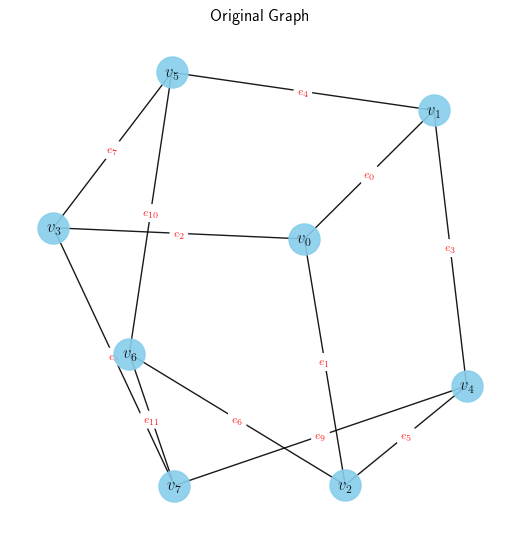

 - Graph with 8 vertices and 12 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.


Dataset contains 5 samples.

Providing more details about sample 4/5:


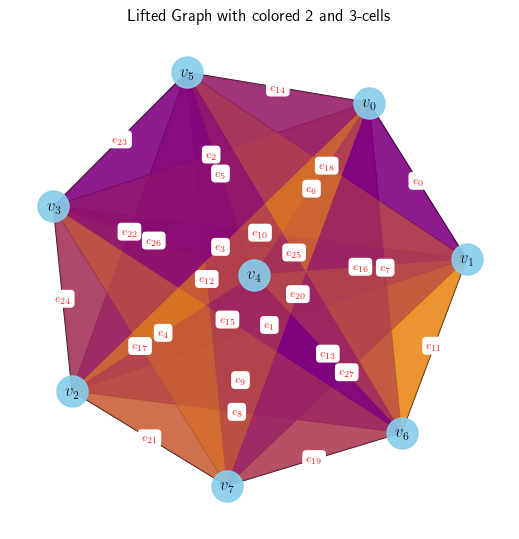

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 28 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 56 2-cells.
 - The 2-cells have features dimension 1
 - The complex has 66 3-cells.
 - The 3-cells have features dimension 1



In [24]:
for i in range(5):
    describe_data(dataset, i)
    describe_data(lifted_dataset, i)